# Blocking Variance Test

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
!pip install progressbar2
import progressbar
from parla.utils.sketching import sjlt_operator

# These test the ACCURACY of the sketch clustering theory

# First sketch: select i.i.d. a constant # within each column

data_matrix_width = 2000
data_matrix_height = int(1e5)
data_matrix_height_width_ratio = int(data_matrix_height / data_matrix_width)
sketch_height = int(data_matrix_width * 3.0)

#X = np.random.rand(data_matrix_height, data_matrix_width)
X = np.tile(np.eye(data_matrix_width), data_matrix_height_width_ratio).T
rows = np.random.randint(low=0, high=X.shape[0], size=X.shape[1])

X[rows, :] *= 1e4

def sketchSklearn(mat, nnz_per_column, output_dim):
    density = nnz_per_column / output_dim
    proj = SparseRandomProjection(n_components=output_dim, density=density)
    return proj.fit_transform(mat.T).T

def sketchParla(mat, nnz_per_column, output_dim):
    sparse_op = sjlt_operator(output_dim, mat.shape[0], np.random.randint(0, 10000), vec_nnz=nnz_per_column)
    return sparse_op @ mat



In [2]:
# Condition number of A_pre = A inv(R)
# Where R is the triangular factor from QR of S@A.

def conditionNumber(A, Ahat):
    q, r = la.qr(Ahat, mode='economic')
    A_pre = la.solve_triangular(r, A.T, trans='T').T
    sigma = la.svd(A_pre, compute_uv=False)
    return sigma[0] / sigma[-1]

#Distortion
#smallest \eta so that (1 - \eta)|| A x || <= || S A x|| <= (1 + \eta) || A x || 
# for all x in R^n

# A distortion of eta ---> the error from preconditioned normal equations decays by
# a factor eta at every step of a subsequent iterative LSQ method, such as CGLS

# Compute eta via bisection, as long as we can verify condition for a single value of eta

# (S A)' (S A) - (1 - \eta)^2 A'A
# and
# (1 + \eta)^2 A'A - (SA)'(SA)
# need to be positive semidefinite

def computeDistortion(A, Ahat, tol=0.005):
    etaMin = 0
    etaMax = 1
    
    sketched = Ahat.T @ Ahat
    original = A.T @ A
    
    while etaMax - etaMin > tol: 
        bothPSD = True
        eta = (etaMin + etaMax) / 2
        try:
            la.cholesky(sketched - (1 - eta) ** 2 * original)
            la.cholesky((1 + eta) ** 2 * original - sketched)
            pass
        except np.linalg.LinAlgError:
            bothPSD = False
            
        if bothPSD:
            etaMax = eta
        else:
            etaMin = eta
        
    return (etaMin + etaMax) / 2


In [3]:
nnz_test = [1, 2, 3, 4, 5, 6, 7, 8]
meanCondition = []
stdCondition = []
meanDistortion = []
stdDistortion = []

for nnz in nnz_test:
    conditionNumbers = []
    distortionFactors = []
    for i in progressbar.progressbar(range(10)):
        Xhat = sketchParla(X, nnz, sketch_height)
        conditionNumbers.append(conditionNumber(X, Xhat))
        distortionFactors.append(computeDistortion(X, Xhat))
    
    meanCondition.append(np.mean(conditionNumbers))
    stdCondition.append(np.std(conditionNumbers))
    
    meanDistortion.append(np.mean(distortionFactors))
    stdDistortion.append(np.std(distortionFactors))
    

100% (10 of 10) |########################| Elapsed Time: 0:03:29 Time:  0:03:29
100% (10 of 10) |########################| Elapsed Time: 0:03:32 Time:  0:03:32
100% (10 of 10) |########################| Elapsed Time: 0:03:34 Time:  0:03:34
100% (10 of 10) |########################| Elapsed Time: 0:03:35 Time:  0:03:35
100% (10 of 10) |########################| Elapsed Time: 0:03:36 Time:  0:03:36
100% (10 of 10) |########################| Elapsed Time: 0:03:37 Time:  0:03:37
100% (10 of 10) |########################| Elapsed Time: 0:03:39 Time:  0:03:39
100% (10 of 10) |########################| Elapsed Time: 0:03:40 Time:  0:03:40


In [4]:
nnz_test = [1, 2, 3, 4, 5, 6, 7, 8]
meanConditionRegular = []
stdConditionRegular = []
meanDistortionRegular = []
stdDistortionRegular = []

Xreg = np.random.standard_normal(X.shape)

for nnz in nnz_test:
    conditionNumbers = []
    distortionFactors = []
    for i in progressbar.progressbar(range(10)):
        Xhat = sketchParla(Xreg, nnz, sketch_height)
        conditionNumbers.append(conditionNumber(Xreg, Xhat))
        distortionFactors.append(computeDistortion(Xreg, Xhat))
    
    meanConditionRegular.append(np.mean(conditionNumbers))
    stdConditionRegular.append(np.std(conditionNumbers))
    
    meanDistortionRegular.append(np.mean(distortionFactors))
    stdDistortionRegular.append(np.std(distortionFactors))

100% (10 of 10) |########################| Elapsed Time: 0:03:45 Time:  0:03:45
100% (10 of 10) |########################| Elapsed Time: 0:03:43 Time:  0:03:43
100% (10 of 10) |########################| Elapsed Time: 0:03:42 Time:  0:03:42
100% (10 of 10) |########################| Elapsed Time: 0:03:43 Time:  0:03:43
100% (10 of 10) |########################| Elapsed Time: 0:03:44 Time:  0:03:44
100% (10 of 10) |########################| Elapsed Time: 0:03:42 Time:  0:03:42
100% (10 of 10) |########################| Elapsed Time: 0:03:44 Time:  0:03:44
100% (10 of 10) |########################| Elapsed Time: 0:03:50 Time:  0:03:50


In [28]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



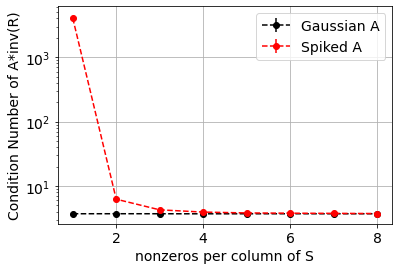

In [41]:
plt.errorbar(nnz_test, meanConditionRegular, np.array(stdConditionRegular), label="Gaussian A",fmt='k--o')
plt.errorbar(nnz_test, meanCondition, np.array(stdCondition), label="Spiked A", fmt='r--o')
plt.xlabel("nonzeros per column of S")
plt.ylabel("Condition Number of A*inv(R)")
plt.grid(True)
plt.legend()
plt.yscale('log')
plt.savefig("riley_img/condition_number.pdf")

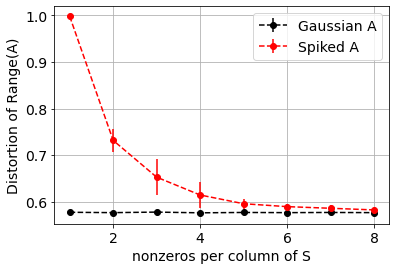

In [40]:
plt.errorbar(nnz_test, meanDistortionRegular, np.array(stdDistortionRegular), label="Gaussian A", fmt='k--o')
plt.errorbar(nnz_test, meanDistortion, np.array(stdDistortion), label="Spiked A", fmt='r--o')
#plt.yscale('log')
plt.xlabel("nonzeros per column of S")
plt.ylabel("Distortion of Range(A)")
plt.grid(True)
plt.legend()
#plt.yscale('log')
plt.savefig("riley_img/distortion_factor.pdf")

In [7]:
import pickle as pkl

In [42]:
results = {
    'normal': {'nnz_test': nnz_test,
               'distortion_mean': meanDistortionRegular,
               'distortion_std': np.array(stdDistortionRegular),
               'cond_mean': meanConditionRegular,
               'cond_std': np.array(stdConditionRegular)},
    'spiked': {'nnz_test': nnz_test,
               'distortion_mean': meanDistortion,
               'distortion_std': np.array(stdDistortion),
               'cond_mean': meanCondition,
               'cond_std': np.array(stdCondition)}
}

In [43]:
f = open('riley_img/plot_data.pkl', 'wb')
pkl.dump(results, f)
f.close()

In [47]:
import time
import parla as rla

In [51]:
rng = np.random.default_rng(42)
for k in range(4,17):
    print(f'k = {k}')
    for i in range(5):
        S = rla.sjlt_operator(sketch_height, data_matrix_height, rng, vec_nnz=k)
        tic = time.time()
        temp = S @ X
        toc = time.time()
        print(toc - tic)

k = 4
5.0732128620147705
2.7994303703308105
2.7195773124694824
2.5841827392578125
2.592409610748291
k = 5
2.8426930904388428
2.7373080253601074
2.660266399383545
2.7920279502868652
2.864082098007202
k = 6
3.1011593341827393
3.0058090686798096
2.930938482284546
2.9714996814727783
2.8826022148132324
k = 7
3.009521722793579
2.9894630908966064
3.063140630722046
2.9822778701782227
2.9301578998565674
k = 8
2.980290412902832
3.007723093032837
2.9705684185028076
2.9661026000976562
3.0683047771453857
k = 9
3.125851631164551
3.235771894454956
3.1018788814544678


KeyboardInterrupt: 